In [8]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from src.crimp import crimp

In [9]:
def topk_from_scores(score_dict, k):
    return [n for n, _ in sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:k]]

def rank_crimp(G):
    return crimp(G).r_imp

def rank_degree(G):
    return {n: float(G.degree(n)) for n in G.nodes()}

def rank_betweenness(G):
    bc = nx.betweenness_centrality(G, normalized=True)
    return {n: float(bc[n]) for n in G.nodes()}

def rank_pagerank(G):
    pr = nx.pagerank(G)
    return {n: float(pr[n]) for n in G.nodes()}

In [10]:
def giant_component_fraction(G):
    """Return size of the largest connected component divided by number of nodes."""
    n = G.number_of_nodes()
    if n == 0:
        return 0.0
    gcc = max((len(c) for c in nx.connected_components(G)), default=0)
    return gcc / n

def targeted_removal_curve(G, ordering):
    """
    Remove nodes in 'ordering' sequentially.
    Returns a DataFrame with fraction removed and gcc fraction after each step.
    """
    H = G.copy()
    n0 = H.number_of_nodes()

    removed = 0
    rows = [{"removed_frac": 0.0, "gcc_frac": giant_component_fraction(H)}]

    for node in ordering:
        if H.has_node(node):
            H.remove_node(node)
            removed += 1
            rows.append({
                "removed_frac": removed / n0,
                "gcc_frac": giant_component_fraction(H)
            })

    return pd.DataFrame(rows)

In [11]:
G = nx.karate_club_graph()

rankers = {
    "CRimp": rank_crimp,
    "Degree": rank_degree,
    "Betweenness": rank_betweenness,
    "PageRank": rank_pagerank,
}

curves = []
for name, fn in rankers.items():
    scores = fn(G)
    ordering = [n for n, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)]
    df_curve = targeted_removal_curve(G, ordering)
    df_curve["method"] = name
    curves.append(df_curve)

perc_df = pd.concat(curves, ignore_index=True)
perc_df.head()

,removed_frac,gcc_frac,method
0,0.000000,1.000000,CRimp
1,0.029412,1.000000,CRimp
2,0.058824,0.812500,CRimp
3,0.088235,0.645161,CRimp
4,0.117647,0.333333,CRimp


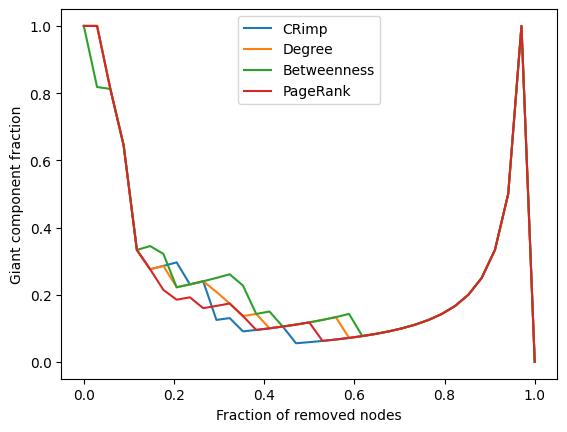

In [12]:
for method in perc_df["method"].unique():
    tmp = perc_df[perc_df["method"] == method]
    plt.plot(tmp["removed_frac"], tmp["gcc_frac"], label=method)

plt.xlabel("Fraction of removed nodes")
plt.ylabel("Giant component fraction")
plt.legend()
plt.show()

In [13]:
def auc(x, y):
    return float(np.trapezoid(y, x))

auc_rows = []
for method in perc_df["method"].unique():
    tmp = perc_df[perc_df["method"] == method]
    auc_rows.append({"method": method, "auc": auc(tmp["removed_frac"].values, tmp["gcc_frac"].values)})

auc_df = pd.DataFrame(auc_rows).sort_values("auc")
auc_df

,method,auc
3,PageRank,0.256046
0,CRimp,0.257694
1,Degree,0.269145
2,Betweenness,0.276905
